In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib_venn import venn3, venn2
import networkx as nx
import gseapy as gp

## Parse IID network, keep only experimentally confirmed interactions with both genes expressed in brain

- Open browser and navigate to http://iid.ophid.utoronto.ca/
- Click on "Download" and download human annotated PPI network.
- Uncompress the network and save it under filename 'human_annotated_PPIs' in this directory.

In [2]:
iid = pd.read_csv('human_annotated_PPIs.txt', sep='\t')

/var/folders/71/cy2w33mn5wng7mg2_mdj3x2h0000gn/T/ipykernel_12448/1041972388.py:1: DtypeWarning: Columns (4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  iid = pd.read_csv('human_annotated_PPIs.txt', sep='\t')


In [3]:
iid_exp = iid[iid.evidence_type.str.contains('exp')]

In [4]:
iid_brain_exp = iid_exp[iid_exp.brain == 2]
iid_brain_exp.reset_index(inplace=True)
iid_brain_exp = iid_brain_exp[['symbol1','symbol2']]

In [5]:
all_nodes = set(iid_brain_exp.symbol1).union(set(iid_brain_exp.symbol2))

In [6]:
iid_brain_exp.to_csv('iid_brain_exp.txt', index=False, sep=' ')

## Read list of differentiall methylated genes, keep only those contained in filtered IID network

In [7]:
all_seeds_l4m = set(pd.read_csv('L4M_promoters.csv', sep=';', index_col=0).index)
all_seeds_re = set(pd.read_csv('RE_promoters.csv', sep=';', index_col=0).index)
all_seeds_scar = set(pd.read_csv('Scar_promoters.csv', sep=';', index_col=0).index)

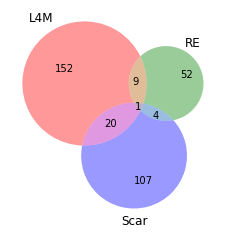

In [8]:
fig, ax = plt.subplots()
venn3([all_seeds_l4m, all_seeds_re, all_seeds_scar], ('L4M', 'RE', 'Scar'), ax=ax)
plt.show()
fig.tight_layout()
fig.savefig('venn.pdf')

In [9]:
seeds_l4m = all_seeds_l4m.intersection(all_nodes)
seeds_re = all_seeds_re.intersection(all_nodes)
seeds_scar = all_seeds_scar.intersection(all_nodes)

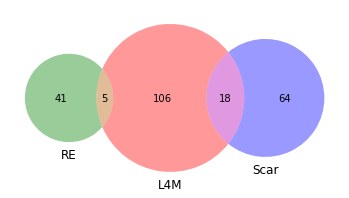

In [10]:
venn3([seeds_l4m, seeds_re, seeds_scar], ('L4M', 'RE', 'Scar'))
plt.show()

In [11]:
def write_seeds(seeds, path):
    with open(path, 'w') as fp:
        fp.write('\n'.join(seeds))

In [12]:
write_seeds(seeds_l4m, 'L4M.txt')
write_seeds(seeds_re, 'RE.txt')
write_seeds(seeds_scar, 'Scar.txt')

## Run ROBUST-Web

*Workflow to generate the file `L4M_09_corrected.graphml` contained in this repository:*

- Open a browser and navigate to https://robust-web.net.
- Click on "Start app".
- Click on "Upload seeds" and upload the file `L4M.txt`.
- Click on "Upload custom network" and then on "Upload network" to upload the file `iid_brain_exp.txt`.
- Click on "OPTIONAL PARAMETERS" and then set the threshold tau to 0.9.
- Click on "Run ROBUST".
- Click on "Download" to download the computed module and rename the file to 'L4M_09_corrected.graphml'.

The files `RE_09_corrected.graphml` and `Scar_09_corrected.graphml` can be generated analogously.

*Workflow for in silico validation with DIGEST to generate the plots contained in `digest` subdirectory:*

- In ROBUST-Web's result view, (manually) select all nodes contained in the largest connected component.
- Then click on "DIGEST Enrichment Analysis".
- In DIGEST's result view, click on "Download all files as .zip" (download symbol in top-right corner).

## Extract LCC from ROBUST modules

In [22]:
def get_lcc(subtype):
    module = nx.read_graphml(f'{subtype}_09_corrected.graphml')
    largest_cc = max(nx.connected_components(module), key=len)
    submodule = module.subgraph(largest_cc).copy()
    for node in submodule.nodes():
        submodule.nodes[node].pop('group',None)
    for node in submodule.nodes():
        if submodule.nodes[node]['_group'] == 'gene':
            submodule.nodes[node]['isSeed'] = False
        else:
            submodule.nodes[node]['isSeed'] = True
        submodule.nodes[node].pop('_group',None)
    nx.write_graphml(submodule, f'{subtype}_LCC_09_corrected.graphml')
    seeds_submodule = set([node[0] for node in submodule.nodes(data=True) if node[1]['isSeed']])
    with open(f'{subtype}_g_profiler_query.txt', 'w') as fp:
        fp.write(' '.join(list(submodule.nodes)))
    return submodule, seeds_submodule

In [44]:
l4m_submodule, l4m_seeds_submodule = get_lcc('L4M')
re_submodule, re_seeds_submodule = get_lcc('RE')
scar_submodule, scar_seeds_submodule = get_lcc('Scar')

## Carry our functional enrichment analysis with g:Profiler

- Open browser and navigate to https://biit.cs.ut.ee/gprofiler/gost
- Run g:GOST with `<SUBTYPE>_g_profiler_query.txt` as input query.

## Compute pageranks within LCC of ROBUST modules

In [45]:
l4m_pagerank_dict = nx.pagerank(l4m_submodule)
l4m_pageranks = list(l4m_pagerank_dict.items())
l4m_pageranks.sort(key = lambda t: t[1], reverse=True)
l4m_top_nodes = [l4m_pageranks[i][0] for i in range(4)]

re_pagerank_dict = nx.pagerank(re_submodule)
re_pageranks = list(re_pagerank_dict.items())
re_pageranks.sort(key = lambda t: t[1], reverse=True)
re_top_nodes = [re_pageranks[i][0] for i in range(4)]

scar_pagerank_dict = nx.pagerank(scar_submodule)
scar_pageranks = list(scar_pagerank_dict.items())
scar_pageranks.sort(key = lambda t: t[1], reverse=True)
scar_top_nodes = [scar_pageranks[i][0] for i in range(4)]

## Plot LCC of ROBUST modules

- Node sizes are proportional to PageRank node centralities (larger nodes are more central)
- Node colors show whether genes are differentially methylated (red) or newly found connectors (blue)
- Four top-ranked nodes with highest PageRank centralities are labeled.

In [29]:
def plot_lcc(submodule, subtype, pageranks, pagerank_dict):
    fig, ax = plt.subplots(figsize=(9,4))
    top_nodes = [pageranks[i][0] for i in range(4)]
    node_labels = {node: node for node in top_nodes}
    node_sizes = [pagerank_dict[node] * 7000 for node in submodule.nodes()]
    node_colors = []
    for node in submodule.nodes(data=True):
        if node[1]['isSeed']:
            node_colors.append('pink')
        else:
            node_colors.append('lightblue')
    nx.draw_networkx(submodule,labels=node_labels,ax=ax,node_color=node_colors,edge_color='grey',
                            node_size=node_sizes,pos=nx.kamada_kawai_layout(submodule))
    fig.tight_layout()
    fig.savefig(f'{subtype}_LCC.pdf')

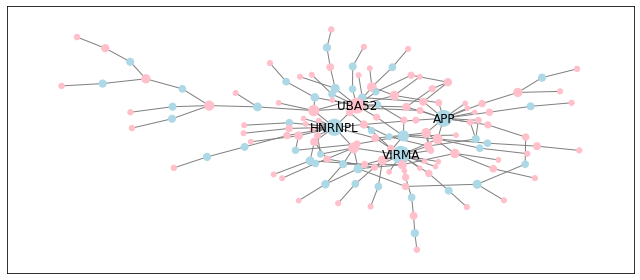

In [30]:
plot_lcc(l4m_submodule, 'L4M', l4m_pageranks, l4m_pagerank_dict)

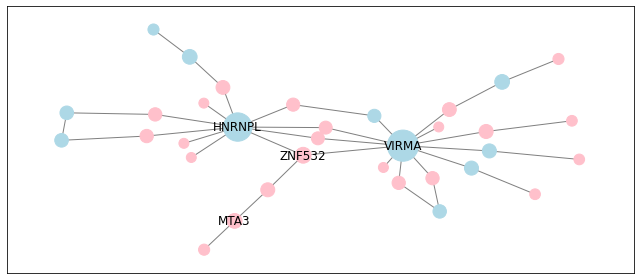

In [32]:
plot_lcc(re_submodule, 'RE', re_pageranks, re_pagerank_dict)

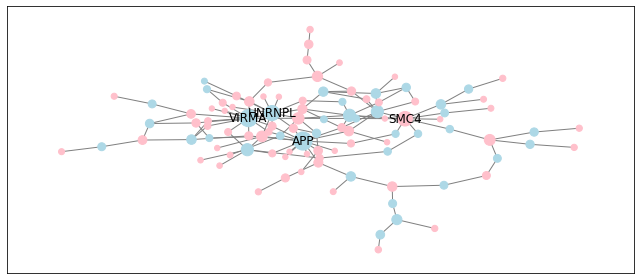

In [46]:
plot_lcc(scar_submodule, 'Scar', scar_pageranks, scar_pagerank_dict)

## Plot top-ranked nodes

In [36]:
def plot_star(module, node, ax=None):
    star = nx.ego_graph(module, node)
    node_shapes = []
    node_colors = []
    for node in star.nodes(data=True):
        if node[1]['isSeed']:
            node_shapes.append('o')
            node_colors.append('pink')
        else:
            node_shapes.append('o')
            node_colors.append('lightblue')
    nx.draw_networkx(star, node_color=node_colors, edge_color='grey', ax=ax)

In [37]:
def plot_stars_for_top_nodes(submodule, top_nodes, subtype):
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(9,5))
    plot_star(submodule, top_nodes[0], ax=axes[0,0])
    plot_star(submodule, top_nodes[1], ax=axes[0,1])
    plot_star(submodule, top_nodes[2], ax=axes[1,0])
    plot_star(submodule, top_nodes[3], ax=axes[1,1])
    fig.tight_layout()
    fig.savefig(f'{subtype}_stars_top_4.pdf')

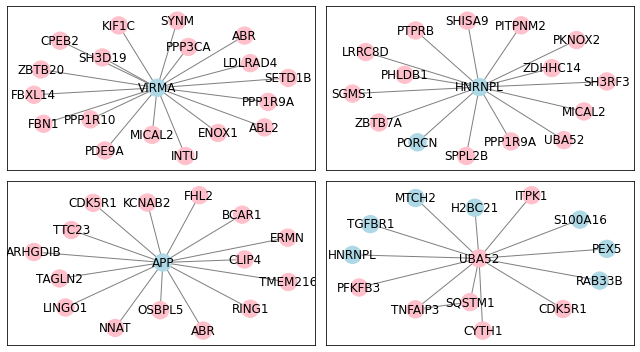

In [38]:
plot_stars_for_top_nodes(l4m_submodule, l4m_top_nodes, 'L4M')

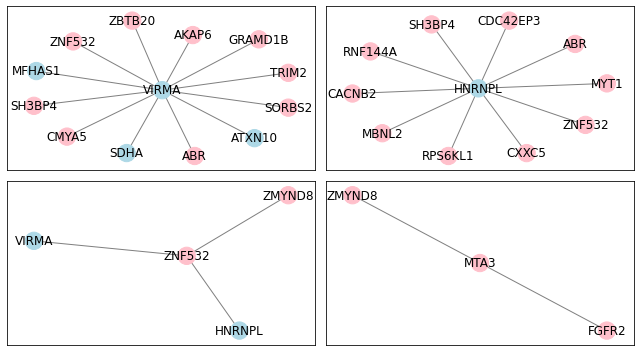

In [39]:
plot_stars_for_top_nodes(re_submodule, re_top_nodes, 'RE')

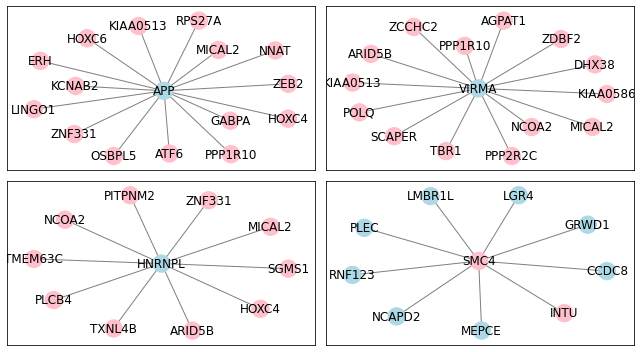

In [47]:
plot_stars_for_top_nodes(scar_submodule, scar_top_nodes, 'Scar')

## Plot LCC of ROBUST module together with top-ranked nodes

In [40]:
def plot_lcc_and_stars_for_top_ranked_nodes(submodule, subtype, pageranks, pagerank_dict, top_nodes):
    fig, axes = plt.subplot_mosaic([['A','A'],['A','A'],['B','C'],['D','E']], figsize=(9,9))
    top_nodes = [pageranks[i][0] for i in range(4)]
    node_labels = {node: node for node in top_nodes}
    node_sizes = [pagerank_dict[node] * 7000 for node in submodule.nodes()]
    node_colors = []
    for node in submodule.nodes(data=True):
        if node[1]['isSeed']:
            node_colors.append('pink')
        else:
            node_colors.append('lightblue')
    nx.draw_networkx(submodule,labels=node_labels,ax=axes['A'],node_color=node_colors,edge_color='grey',
                     node_size=node_sizes,pos=nx.kamada_kawai_layout(submodule))
    plot_star(submodule, top_nodes[0], ax=axes['B'])
    plot_star(submodule, top_nodes[1], ax=axes['C'])
    plot_star(submodule, top_nodes[2], ax=axes['D'])
    plot_star(submodule, top_nodes[3], ax=axes['E'])
    fig.tight_layout()
    fig.savefig(f'{subtype}_LCC_stars_top_4.pdf')

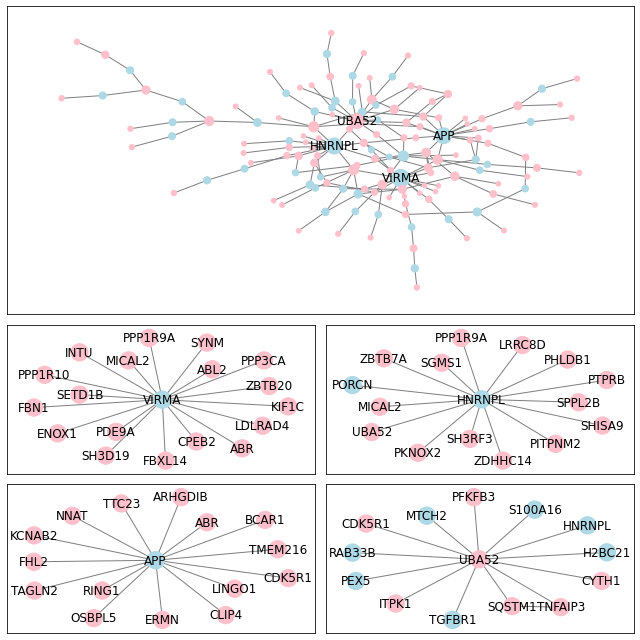

In [41]:
plot_lcc_and_stars_for_top_ranked_nodes(l4m_submodule, 'L4M', l4m_pageranks, l4m_pagerank_dict, l4m_top_nodes)

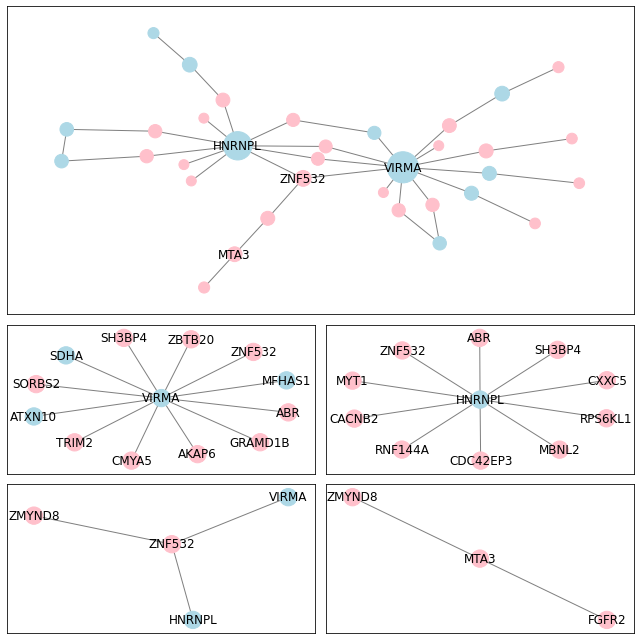

In [42]:
plot_lcc_and_stars_for_top_ranked_nodes(re_submodule, 'RE', re_pageranks, re_pagerank_dict, re_top_nodes)

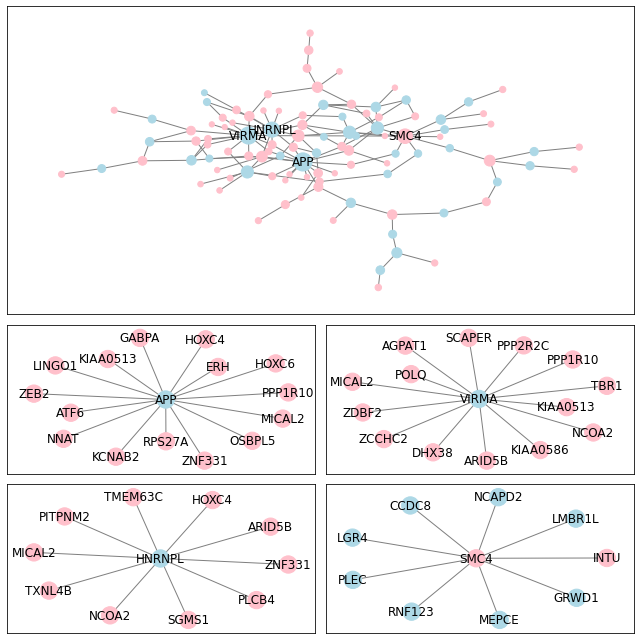

In [48]:
plot_lcc_and_stars_for_top_ranked_nodes(scar_submodule, 'Scar', scar_pageranks, scar_pagerank_dict, scar_top_nodes)